Link to colab: https://colab.research.google.com/drive/12gdVV57fZsK5zbpVVTLQngDeihoVUkEz



link to dataset: https://www.kaggle.com/murderaccountability/homicide-reports



#Intro

The dataset that has been used in this paper has been obtained through Kaggle.com and contains over half a million of different cases of manslaughters/murders in the United States of America, with negligence as a differentiator. The dataset has a span of 34 years from 1980 to 2014. The dataset itself contained more than 600.000 entries.

We import the dataset that we will use in the assignment. Its called "homicide report, 1980-2014"

In [1]:
#We mount a local google drive with colab
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#From our local drive we import a dataset from a personal directory. 
import pandas as pd 
crimedata=pd.read_csv('gdrive/My Drive/Colab Notebooks/database 3.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#We import all the things we will use later at once. 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import sklearn.tree 
import graphviz
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn.ensemble import ExtraTreesClassifier

In [4]:
# We run a .head to inspect the structure of the dataset. 
crimedata.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,Yes,Male,14,Native American/Alaska Native,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


#Cleaning

In [5]:
#We run a .info to see that the dataset is uploaded correctly and what variables it contains. Including their type. 
crimedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638454 entries, 0 to 638453
Data columns (total 24 columns):
Record ID                638454 non-null int64
Agency Code              638454 non-null object
Agency Name              638454 non-null object
Agency Type              638454 non-null object
City                     638454 non-null object
State                    638454 non-null object
Year                     638454 non-null int64
Month                    638454 non-null object
Incident                 638454 non-null int64
Crime Type               638454 non-null object
Crime Solved             638454 non-null object
Victim Sex               638454 non-null object
Victim Age               638454 non-null int64
Victim Race              638454 non-null object
Victim Ethnicity         638454 non-null object
Perpetrator Sex          638454 non-null object
Perpetrator Age          638454 non-null object
Perpetrator Race         638454 non-null object
Perpetrator Ethnicity    6384

The first step is to clean the data in the dataset. 


In [6]:
#We want to see the amount of cases that are unsolved since those files will probably contain missing information. 
Solved = crimedata["Crime Solved"].str.contains("Yes", case = False, na = False)
Unsolved = crimedata["Crime Solved"].str.contains("No", case = False, na = False)
print("Solved Crimes: ", len(crimedata[Solved].index))
print("Unsolved Crimes: ", len(crimedata[Unsolved].index))

Solved Crimes:  448172
Unsolved Crimes:  190282


In [0]:
#So there are over 190000 cases of unsolved crimes. First we drop all unsolved crimes. 
crimedata_unsolved=crimedata["Crime Solved"]=="No"
crimedata.drop((crimedata[crimedata_unsolved].index), inplace=True)


In [8]:
# We now inspect if there are missing data regarding race
unknown_race_perp = crimedata["Perpetrator Race"].str.contains("Unknown", case = False, na = False)
print("The amount of crimes commited by a perpetrator of unknown race is ", len(crimedata[unknown_race_perp].index))

unknown_race_vic = crimedata["Victim Race"].str.contains("Unknown", case = False, na = False)
print("The amount of crimes commited by a Victim of unknown race is ", len(crimedata[unknown_race_vic].index))

The amount of crimes commited by a perpetrator of unknown race is  6049
The amount of crimes commited by a Victim of unknown race is  3592


In [0]:
# So we need to drop around 9500 unknown data.
crimedata_unknown_vic=crimedata["Victim Race"]=="Unknown"
crimedata.drop((crimedata[crimedata_unknown_vic].index), inplace=True)

crimedata_unknown_perp=crimedata["Perpetrator Race"]=="Unknown"
crimedata.drop((crimedata[crimedata_unknown_perp].index), inplace=True)




In [10]:
#To control the instances in which the amount of victims have been left out, we do a value_count command. This would indicate missing information in the dataframe.
crimedata["Victim Count"].value_counts()

0     402891
1      26462
2       6234
3       2122
4        814
5        433
6        258
9        230
10       160
7        158
8        123
Name: Victim Count, dtype: int64

In [11]:
#Since there is about 400.000 instances in which this information has been left out, we choose to drop this column from the dataframe, since simply removing all rows with this being the case
#Would result in a massive loss of data. The same goes for Perpetrator Count.
#We will remove non-relevant data from the dataset. Clean means that we have dropped all unnecesary variables. Ethnicity only shows "hispanic" and "non-hispanic" and we therefore find it irrelevant. 
crimedata_clean = crimedata.drop(["Victim Ethnicity", "Perpetrator Ethnicity", "Agency Code", "Agency Name", "Agency Type", "Record Source", "Record ID", "Crime Solved", "Incident", "Victim Count", "Perpetrator Count"], 1)
#So these are the columns that form our basis for our clean datasat, and the rest of our dataset. 
crimedata_clean.head(1)

,City,State,Year,Month,Crime Type,Victim Sex,Victim Age,Victim Race,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon
0,Anchorage,Alaska,1980,January,Murder or Manslaughter,Male,14,Native American/Alaska Native,Male,15,Native American/Alaska Native,Acquaintance,Blunt Object


In [12]:
# From the .info earlier we can see that the perpetrator age is being listed as an object. That seems quite odd, which is why we convert it into a int before going through the rest of the variables. We start by converting numerics. 
encoder = LabelEncoder()
crimedata_clean= crimedata_clean.convert_objects(convert_numeric=True)
crimedata_clean["Perpetrator Age"]=encoder.fit_transform(crimedata_clean["Perpetrator Age"])

#To make sure that there are no invalid inputs in perpetrator age, we also make sure to drop values below the convictable age, which is 6 years old(!) at its lowest in the US.
crimedata_low=crimedata_clean["Perpetrator Age"]<=5
crimedata_clean.drop((crimedata_clean[crimedata_low].index), inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


#Exploration and fun with statistics

The first thing we want to look at, with our new clean dataset is interracial murders. We have a hypothesis based on the tv-series "Mindhunter" which is that killers often murder within their own race and that interracial murders are rare. We want to see if that really is the case in a general sense.

In [13]:

#We would like to see the amount of crimes by each individual race
crime_white_perp = crimedata_clean["Perpetrator Race"].str.contains("White", case = False, na = False)
crime_black_perp = crimedata_clean["Perpetrator Race"].str.contains("Black", case = False, na = False)
crime_native_perp = crimedata_clean["Perpetrator Race"].str.contains("Native", case = False, na = False)
crime_asian_perp = crimedata_clean["Perpetrator Race"].str.contains("Asian/Pacific Islander", case = False, na = False)

print("The amount of crimes commited by white perpetrators is ", len(crimedata_clean[crime_white_perp]))
print("The amount of crimes commited by black perpetrators is ", len(crimedata_clean[crime_black_perp]))
print("The amount of crimes commited by asian or pacific perpetrators is ", len(crimedata_clean[crime_asian_perp]))
print("The amount of crimes commited by native perpetrators is ", len(crimedata_clean[crime_native_perp]))

The amount of crimes commited by white perpetrators is  209726
The amount of crimes commited by black perpetrators is  197303
The amount of crimes commited by asian or pacific perpetrators is  5774
The amount of crimes commited by native perpetrators is  3503


In [14]:
#We compare the murders across different races. 
pd.crosstab(crimedata_clean["Perpetrator Race"], crimedata_clean["Victim Race"])

Victim Race,Asian/Pacific Islander,Black,Native American/Alaska Native,White
Perpetrator Race,,,,
Asian/Pacific Islander,3742,521,29,1482
Black,1119,166151,373,29660
Native American/Alaska Native,34,181,1963,1325
White,1644,16034,1130,190918


So our hypothesis was actually correct on white and black people. That makes sense, because the two big groups are represented in the dataset. Even with asians and natives the homicide rate is still above 50% of same-race homicides.  


In percent its

*  white on white = 90.85%
*  black on black = 83.95%
*  asian on asian = 64.67%
* native on native = 56.13%





We want to look at homicide statstics ranging from 1980 to 2014 to investigate the development from then to now. 


In [0]:
#We make a copy of our dataset. We do that because the datetime-function we add, means that other commands in our assignment can't run. 
crimedata_clean_plot = crimedata_clean.copy()

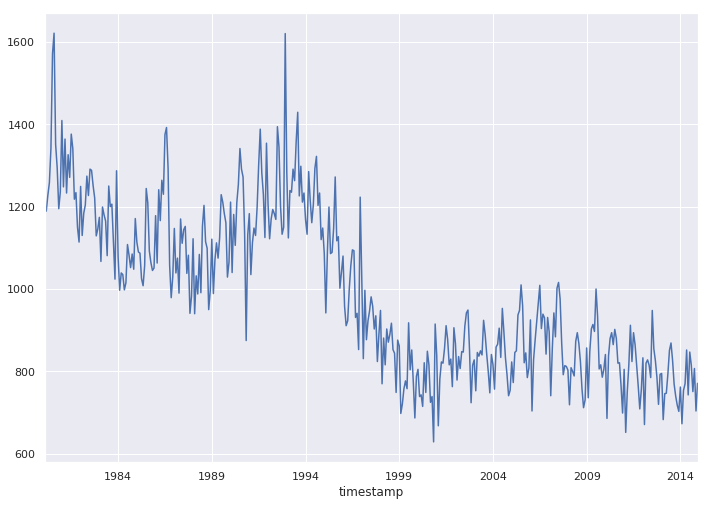

In [48]:
#We begin to make a datatime function in our new dataset. A problem is that "Month" is a string, while "Year" is an int. Therefore, we run both as a string. 
date_cleaning = crimedata_clean_plot.Month.str.cat(crimedata_clean_plot.Year.astype(str), sep='-')
crimedata_clean_plot['timestamp'] = pd.to_datetime(date_cleaning)
crimedata_clean_plot.set_index('timestamp', inplace=True)

# Lets get a graphic view of the homicides between 1980 and 2014.
crimedata_clean_plot[crimedata_clean_plot.index > pd.to_datetime('1-1-1980')].resample('M').size().plot()

There have been a distinct drop in homicides through the years.
Now for the fun part. Is it possible to to find a fun correlation with drops and rises in homicides throughout the ages? 

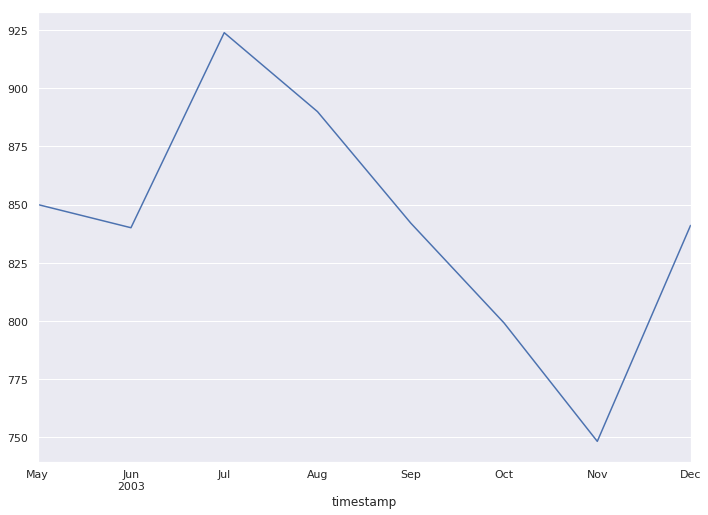

In [49]:
# Now it gets interesting! It looks like there is a drop in homicides after the release of "The Black Eyed Peas" song "Where is the love". 
crimedata_clean_plot[(crimedata_clean_plot.index > pd.to_datetime('4-1-2003')) & (crimedata_clean_plot.index < pd.to_datetime('1-1-2004'))].resample('M').size().plot()

Since the song was released in late June 2003, there seems to be quite a dip in homicides. The dip correlates with the popularity of "Where is the love?" in the US.

A deeper analysis of this phenomenon can be found in our stakeholder report. 

#Unsupervised machine learning

Its now time for some machine learning. We begin with unsupervised which simply means that the machine learning runs without explicit instructions on what to do. 
We begin with a PCA. 

PCA-analysis

In [18]:
#First we do a .info command to examine the datatypes in the dataframe.
crimedata_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416306 entries, 0 to 638453
Data columns (total 13 columns):
City                416306 non-null object
State               416306 non-null object
Year                416306 non-null int64
Month               416306 non-null object
Crime Type          416306 non-null object
Victim Sex          416306 non-null object
Victim Age          416306 non-null int64
Victim Race         416306 non-null object
Perpetrator Sex     416306 non-null object
Perpetrator Age     416306 non-null int64
Perpetrator Race    416306 non-null object
Relationship        416306 non-null object
Weapon              416306 non-null object
dtypes: int64(3), object(10)
memory usage: 44.5+ MB


In [19]:
#Now we transform all the data in the dataframe into int64. This means we can scale and use the data in Machine Learning. Objects such as City or State will now be given individual numerical values.
#Eg. Male = 1, Female = 0. 
crimedata_converted = crimedata_clean.apply(LabelEncoder().fit_transform)
#To check if we succeded we do a .info again.
crimedata_converted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416306 entries, 0 to 638453
Data columns (total 13 columns):
City                416306 non-null int64
State               416306 non-null int64
Year                416306 non-null int64
Month               416306 non-null int64
Crime Type          416306 non-null int64
Victim Sex          416306 non-null int64
Victim Age          416306 non-null int64
Victim Race         416306 non-null int64
Perpetrator Sex     416306 non-null int64
Perpetrator Age     416306 non-null int64
Perpetrator Race    416306 non-null int64
Relationship        416306 non-null int64
Weapon              416306 non-null int64
dtypes: int64(13)
memory usage: 44.5 MB


In [20]:
#And a .head to see what it looks like in the dataset
crimedata_converted.head(1)

,City,State,Year,Month,Crime Type,Victim Sex,Victim Age,Victim Race,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon
0,35,1,0,4,1,1,14,2,1,9,2,0,0


In [21]:
#In order to conduct the PCA, we first need to scale our data. This is done by making a scaler. 
scaler = StandardScaler()
crimedata_scaled = scaler.fit_transform(crimedata_converted)

#We define the amount of components
pca = PCA(n_components=8)

#Now we reduce our data.
crimedata_reduced = pca.fit_transform(crimedata_scaled)

#Now we examine if the shape of the reduced dataset is correct.
crimedata_reduced.shape

(416306, 8)

0.7320005268215356

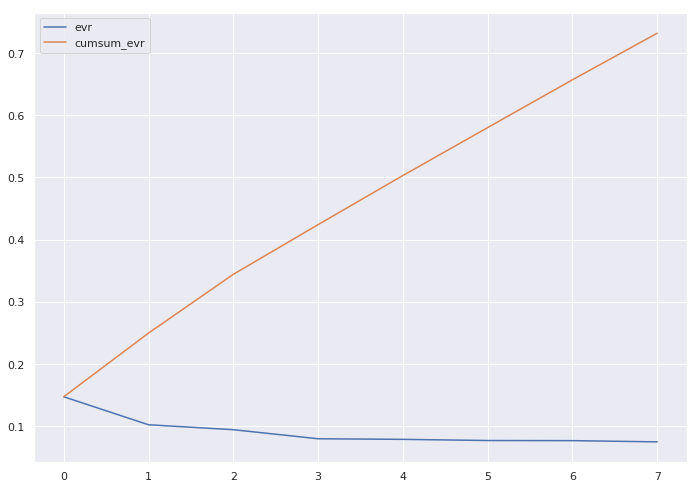

In [22]:
#Now we check how much of the data variance the machine can explain with our n_components set to 8.
crimedata_plot = pd.DataFrame({'evr': pca.explained_variance_ratio_, 'cumsum_evr': np.cumsum(pca.explained_variance_ratio_)}).stack()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(y = crimedata_plot.values, x = crimedata_plot.index.get_level_values(0), hue=crimedata_plot.index.get_level_values(1))
pca.explained_variance_ratio_.sum()

Based on the n_components being set to 8, there is approx. a quarter of our dataset that can't be explained. This would increase drastically, should we chose to use less components, with one component only explaining 15% of the variance. 

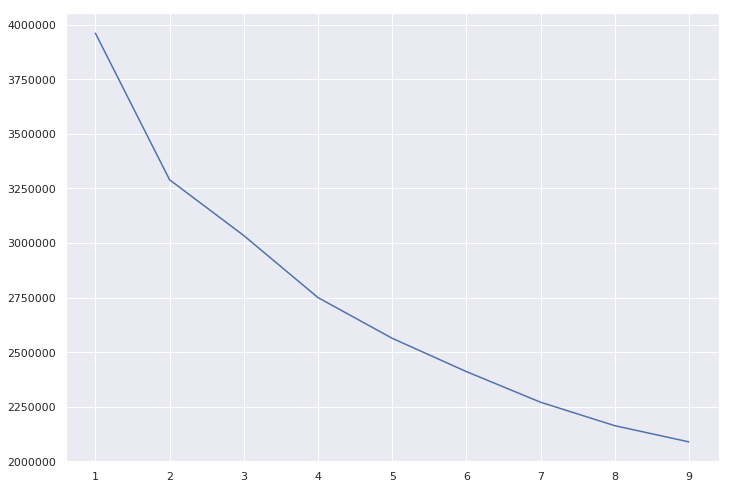

In [23]:
#Now we prepare to cluster our data. We do this by using the elbow-method for choosing a practical amount of clusters.
inertia = []
for i in range(1,10):
 k_means = KMeans(n_clusters=i)
 inertia.append(k_means.fit(crimedata_reduced).inertia_)
sns.lineplot(y = inertia, x = range(1,10))

In [24]:
#We can see, that there seems to be a drop in data after just about 4 clusters. So we choose 4 clusters.
clusterer = KMeans(n_clusters=4)
clusterer.fit(crimedata_reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

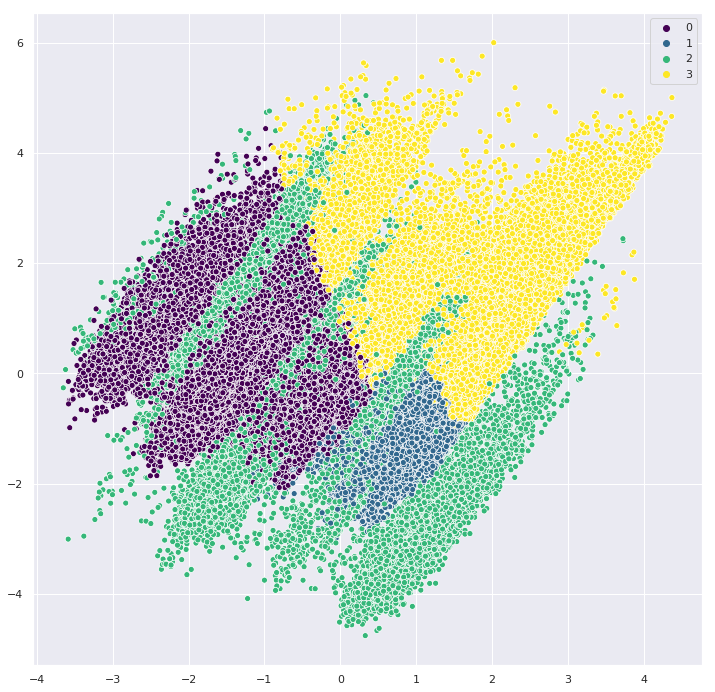

In [25]:
#We examine how the machine have clustered based on the variables in the dataset. 
plt.figure(figsize=(12,12))
g = sns.scatterplot(crimedata_reduced[:,0], crimedata_reduced[:,1], hue=clusterer.labels_,
              legend='full', palette='viridis')
legend = g.get_legend()

In [26]:
crimedata_converted['cluster'] = clusterer.labels_
crimedata_converted.groupby("cluster",).mean()

,City,State,Year,Month,Crime Type,Victim Sex,Victim Age,Victim Race,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon
cluster,,,,,,,,,,,,,
0,879.975260,24.374582,16.316328,5.464121,1.000000,0.817347,29.439019,1.087070,0.992731,21.404623,1.042922,13.848404,7.776157
1,931.967299,21.676096,13.334575,5.472391,1.000000,0.838091,28.975291,2.880783,0.996727,20.765090,2.796180,15.111840,7.710388
2,889.258896,23.581678,13.476178,5.484621,0.824561,0.783030,29.736758,1.932599,0.145721,24.634980,1.936009,10.332162,8.215285
3,889.143283,25.510271,18.922280,5.424546,0.999648,0.381057,52.303197,2.724309,0.937715,40.039817,2.612570,18.120491,7.773890


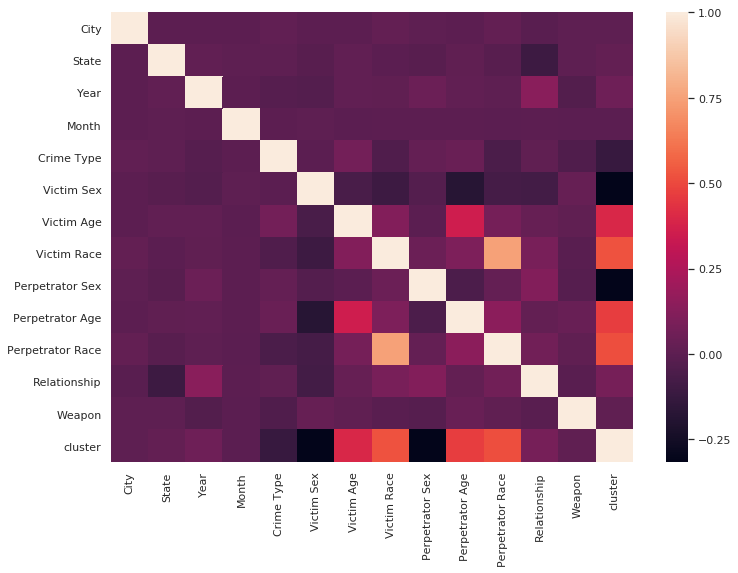

In [27]:
#We want to see how different columns correlate with eachother, and how the clusters correlate with variables. 
corr_vars = crimedata_converted.corr()
sns.heatmap(corr_vars)

It's especially Victim Race and Perpetrator Race that correlate with eachother. The same goes for the clusters. We can also see a connection between victim and perpetrator age. 

#Supervised machinelearning

In [28]:
#First we look at the different columns in the dataset
crimedata_converted.columns

Index(['City', 'State', 'Year', 'Month', 'Crime Type', 'Victim Sex',
       'Victim Age', 'Victim Race', 'Perpetrator Sex', 'Perpetrator Age',
       'Perpetrator Race', 'Relationship', 'Weapon', 'cluster'],
      dtype='object')

In [29]:
#We drop information about the perpetrator and the relationship to the victim. 
crime_info = crimedata_converted.drop(["Perpetrator Sex", "Perpetrator Age", "Perpetrator Race", "Relationship"],1)

#Checking to see if they correctly have been dropped from our crime_info.
crime_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416306 entries, 0 to 638453
Data columns (total 10 columns):
City           416306 non-null int64
State          416306 non-null int64
Year           416306 non-null int64
Month          416306 non-null int64
Crime Type     416306 non-null int64
Victim Sex     416306 non-null int64
Victim Age     416306 non-null int64
Victim Race    416306 non-null int64
Weapon         416306 non-null int64
cluster        416306 non-null int32
dtypes: int32(1), int64(9)
memory usage: 33.3 MB


In [0]:
#Now we will define the training set for out Machine Learning

x = crime_info.loc[:, "City":"Weapon"]
y = crimedata_converted["Perpetrator Race"]

encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

#We split it in a test set being 25% of our dataset, and the remaining 75% being our training set. The random state is random and is set at 42, the answer to everything. 
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_enc, random_state = 42, test_size = 0.25)

In [31]:
#We use the logistic regression function to get the n-fold cross validation
model_lr = LogisticRegression()

#We want our score with the training set from the logisticregression that we just made. We set our cross validation to 4, so 3 of them can test the training data, and 1 can evaluate our results. 
scores = cross_val_score(model_lr, x_train, y_train, cv = 4)
print(scores)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

[0.86204025 0.86137231 0.86189579 0.86267376]


## Logistic Regression

In [32]:
# The logistic regression is the first of our models. This is meant for binary outcomes, meaning finding true and false. This data has four possible outcomes.
# But for fun we still try to run the algoritm.
model_lr.fit(x_train, y_train)
print(model_lr.score(x_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8603341756584068


## Decision Tree

In [33]:
#For the secound algoritm we use randomforestclassifier. 
model_tree = RandomForestClassifier(n_estimators=100,max_depth=7)
model_tree.fit(x_train, y_train)
y_pred =  model_tree.predict(x_test)

print('Accuracy Score on train data: ', accuracy_score(y_true=y_train, y_pred=model_tree.predict(x_train)))
print('Accuracy Score on test data: ', accuracy_score(y_true=y_test, y_pred=y_pred))

Accuracy Score on train data:  0.8714116882160209
Accuracy Score on test data:  0.8694716411887352


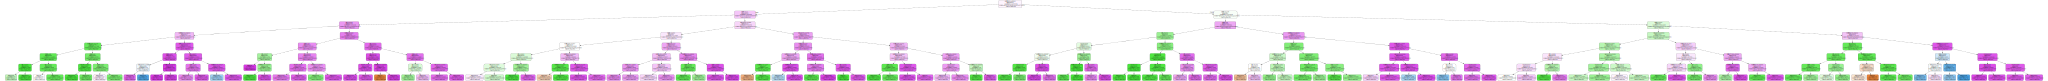

In [34]:
# To get a understanding of how the machine evaluates the race of the perpetrator, we visualize our decision tree and the different outcomes.    
import sklearn.tree 
import graphviz 

# Extract single tree
estimator = model_tree.estimators_[4]

dot_data = dot_crimeinfo = sklearn.tree.export_graphviz(estimator, out_file=None, 
               feature_names=x.columns,  
                class_names=['Race 0', 'Race 1', "Race 2", "Race 3"] , filled=True, rounded=True,  special_characters=True)  
Crimedata_graph = graphviz.Source(dot_data) 
#The decision tree over how the mascine thinks, can now be shown visually
Crimedata_graph

## Extreme Gradient Boost algorithm

In [35]:
#Lastly, we use the XGBClassifier because it both is fast and accurate to proces structurated data. 
model_xgb = xgb.XGBClassifier()
model_xgb.fit(x_train, y_train)
print(model_xgb.score(x_test, y_test))

0.87112426376625


#Validating Models

In [36]:
#First we check what the values in the validation corresponds to. We run all algorithms against the full dataset, and match the "support" column to the actual results commited by each race.
print("The amount of crimes commited by white perpetrators is ", len(crimedata_clean[crime_white_perp]))
print("The amount of crimes commited by black perpetrators is ", len(crimedata_clean[crime_black_perp]))
print("The amount of crimes commited by asian or pacific perpetrators is ", len(crimedata_clean[crime_asian_perp]))
print("The amount of crimes commited by native perpetrators is ", len(crimedata_clean[crime_native_perp]))

The amount of crimes commited by white perpetrators is  209726
The amount of crimes commited by black perpetrators is  197303
The amount of crimes commited by asian or pacific perpetrators is  5774
The amount of crimes commited by native perpetrators is  3503


For reference:
*   Race 0 = Asian/Pacific Perpetrator
*   Race 1 = Black Perpetrator
*   Race 2 = Native Perpetrator
*   Race 3 = White Perpetrator

In [37]:
#Testing the Logistic Regression algorithm on test set
model_lr.fit(x_train, y_train)
predictions_lr = model_lr.predict(x_test)
print(model_lr.score(x_test, y_test))
print(classification_report(y_test, predictions_lr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8603341756584068
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1531
           1       0.87      0.85      0.86     49370
           2       0.00      0.00      0.00       881
           3       0.85      0.91      0.88     52295

    accuracy                           0.86    104077
   macro avg       0.43      0.44      0.43    104077
weighted avg       0.84      0.86      0.85    104077



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
#Checking accuracy on Logistic Regression algorithm on full set
model_lr.fit(x_train,y_train)
crime_lr = model_lr.predict(x_scaled)
print(model_lr.score(x_test, y_test))
print(classification_report(y, crime_lr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8603341756584068


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5774
           1       0.87      0.85      0.86    197303
           2       0.00      0.00      0.00      3503
           3       0.85      0.91      0.88    209726

    accuracy                           0.86    416306
   macro avg       0.43      0.44      0.44    416306
weighted avg       0.84      0.86      0.85    416306



In [39]:
#Testing the decision tree algorithm on test set
estimator.fit(x_train, y_train)
predictions_tree = estimator.predict(x_test)
print(estimator.score(x_test, y_test))
print(classification_report(y_test, predictions_tree))

0.8506874717757045
              precision    recall  f1-score   support

           0       0.56      0.27      0.36      1531
           1       0.89      0.81      0.85     49370
           2       0.60      0.34      0.43       881
           3       0.83      0.91      0.87     52295

    accuracy                           0.85    104077
   macro avg       0.72      0.58      0.63    104077
weighted avg       0.85      0.85      0.85    104077



In [40]:
#Checking accuracy on decision tree algorithm on full set
estimator.fit(x_train,y_train)
crime_tree = estimator.predict(x_scaled)
print(estimator.score(x_test, y_test))
print(classification_report(y, crime_tree))

0.8506874717757045
              precision    recall  f1-score   support

           0       0.56      0.27      0.36      5774
           1       0.89      0.81      0.85    197303
           2       0.57      0.32      0.41      3503
           3       0.83      0.91      0.87    209726

    accuracy                           0.85    416306
   macro avg       0.71      0.58      0.62    416306
weighted avg       0.85      0.85      0.85    416306



In [41]:
#Checking accuracy on XGB algorithm on test set
model_xgb.fit(x_train, y_train)
predictions_XGB = model_xgb.predict(x_test)
print(model_xgb.score(x_test, y_test))
print(classification_report(y_test, predictions_XGB))

0.87112426376625
              precision    recall  f1-score   support

           0       0.60      0.64      0.62      1531
           1       0.91      0.84      0.87     49370
           2       0.64      0.52      0.57       881
           3       0.85      0.91      0.88     52295

    accuracy                           0.87    104077
   macro avg       0.75      0.73      0.74    104077
weighted avg       0.87      0.87      0.87    104077



In [42]:
#Checking accuracy on XGB algorithm on full set
model_xgb.fit(x_train,y_train)
crime_xgb = model_xgb.predict(x_scaled)
print(model_xgb.score(x_test, y_test))
print(classification_report(y, crime_xgb))

0.87112426376625
              precision    recall  f1-score   support

           0       0.58      0.64      0.61      5774
           1       0.91      0.84      0.87    197303
           2       0.63      0.50      0.56      3503
           3       0.85      0.91      0.88    209726

    accuracy                           0.87    416306
   macro avg       0.74      0.72      0.73    416306
weighted avg       0.87      0.87      0.87    416306



## Most important information when calculating perpetrator race

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.07414659 0.05413882 0.07909198 0.06966412 0.0013708  0.00421186
 0.11496947 0.57099362 0.03141274]


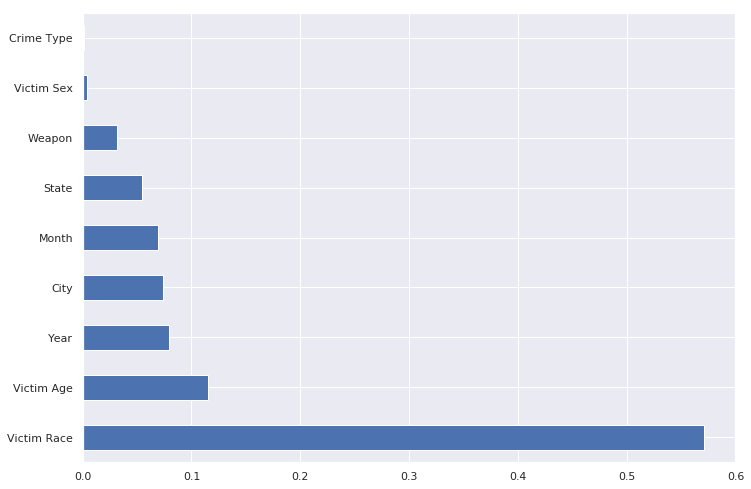

In [43]:
#To get a understanding of the importances of the different variables when identifying perpetrator race we do this. 
x1 = crime_info.loc[:, "City": "Weapon"]  
y1 = crimedata_converted["Perpetrator Race"] 
modeltest = ExtraTreesClassifier()
modeltest.fit(x1,y1)
print(modeltest.feature_importances_) 

#plot graph of feature importances for better visualization
feat_importances = pd.Series(modeltest.feature_importances_, index=x1.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

It seems that the Machine calculates Perpetrator Race based primarily on the race of the victim. This corresponds with our own hypothesis from Mindhunter, where interracial murders are less common. 

## Confusion Matrix

In [44]:
#We install necessary pack for creating confusion matrix. 
!pip install -U mlxtend

     |████████████████████████████████| 1.3MB 4.9MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


We will use the confusion matrix, to see how well our different models can predict the race correctly. The cool thing with the confusion matrix is that when the machine guesses wrong, you can see what it guessed. 

(<Figure size 842.4x595.44 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f336bd63c18>)

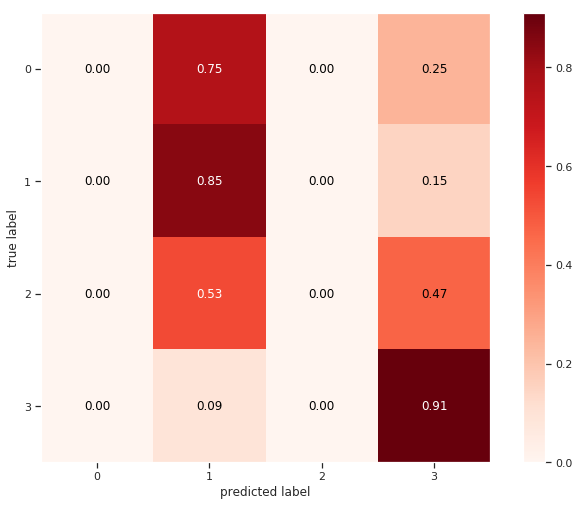

In [45]:
# calculate the confusion matrix for logistic regression 
confmatrix_lr = confusion_matrix(y_test, predictions_lr) 

# Let's plot
plot_confusion_matrix(conf_mat=confmatrix_lr,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                cmap=plt.cm.Reds)

The test results are now displayed, and we see why the logistic regression isn't very good at handling multiple outcomes. The model always guesses that the perpetrators race is either black or white and totally ignoring asian and natives. It guesses black perpetrators correct 85% of the time and 15% of the time it guesses wrong. The same numbers are 91% correct and 9% wrong for white perpetrators. 

We run the same confusion matrix, but this time on our decision tree. 

(<Figure size 842.4x595.44 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f336bc9fd30>)

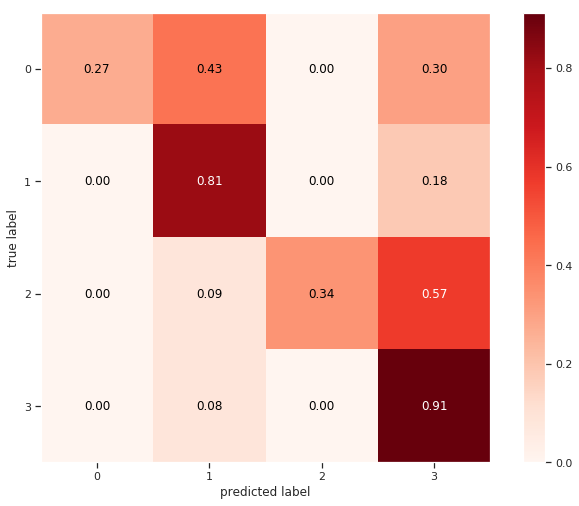

In [46]:
# calculate the confusion matrix for our decision tree
confmatrix_tree = confusion_matrix (y_test, predictions_tree) 

# Let's plot
plot_confusion_matrix(conf_mat=confmatrix_tree,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                cmap=plt.cm.Reds)

Better. The decison tree have about the same successrate for black and white perpetrators at 
respectively 84% and 91%. But this time the model also tries to guess asian/pacific and native perpetrators with varying success. It guesses asian/pacific perpetrators correct 64% of the time, and native perpetrators correct only half of the time. The lower numbers can be explained with the fact, that murders in the same race is much more common with white and black perpetrators, making it harder to make a pattern.

Lastly we run the confussion matrix on our extreme gradient booster

(<Figure size 842.4x595.44 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f336bc363c8>)

<Figure size 842.4x595.44 with 0 Axes>

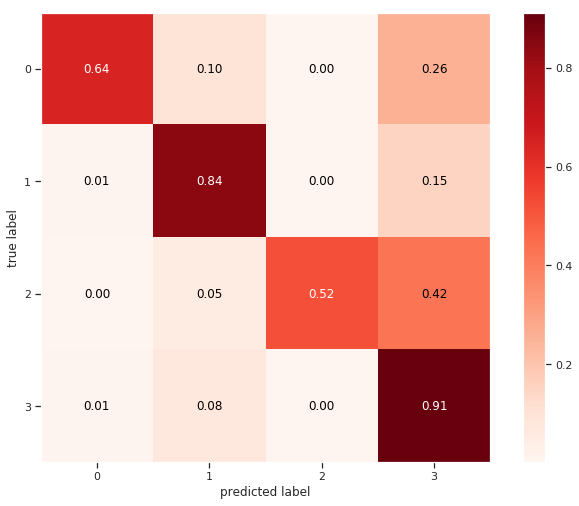

In [47]:
# calculate the confusion matrix for XGB
confmatrix_XGB = confusion_matrix (y_test, predictions_XGB) 

plt.set_cmap("Blues")
# Let's plot
plot_confusion_matrix(conf_mat=confmatrix_XGB,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,
                                cmap=plt.cm.Reds)

It's very similar to our decision tree, with successrate of 84% and 91% for black and white perpetrators and 64% and 52% for asian/pacific and native perpetrators. 

All in all it can be concluded that our decision tree and extreme gradient booster are the best models to predict a perpetrator race. They are really effective with white and black perpetrators, but less successfull with asian/pacific and native perpetrators. The XGB is better for bigger datasets since it uses less computing power.